本笔记本为[教科书](http://manipulation.csail.mit.edu/pick.html)提供了配套示例。建议将两个窗口并排打开！

In [1]:
import numpy as np
from pydrake.all import (
    DiagramBuilder,
    Integrator,
    JacobianWrtVariable,
    LeafSystem,
    Simulator,
    StartMeshcat,
    # ... 其他需要的模块 ...
    plot_system_graphviz
)

from manipulation import running_as_notebook
from manipulation.station import LoadScenario, MakeHardwareStation  # 导入场景和硬件站

In [2]:
# 启动可视化工具。
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# 我们的第一个末端执行器“控制器”

让我们用雅可比伪逆来驱动机器人运动。为此，我们将编写一个非常简单的系统：读取当前的 $q$，计算 $[J^G]^+$，并用它来指令一个恒定的空间速度 $V^G$。

我们只会让这个控制器运行很短的时间。恒定的空间速度并不适合长时间仿真！

请务必尝试更改 $V^G$，并理解指令与机器人运动之间的关系。

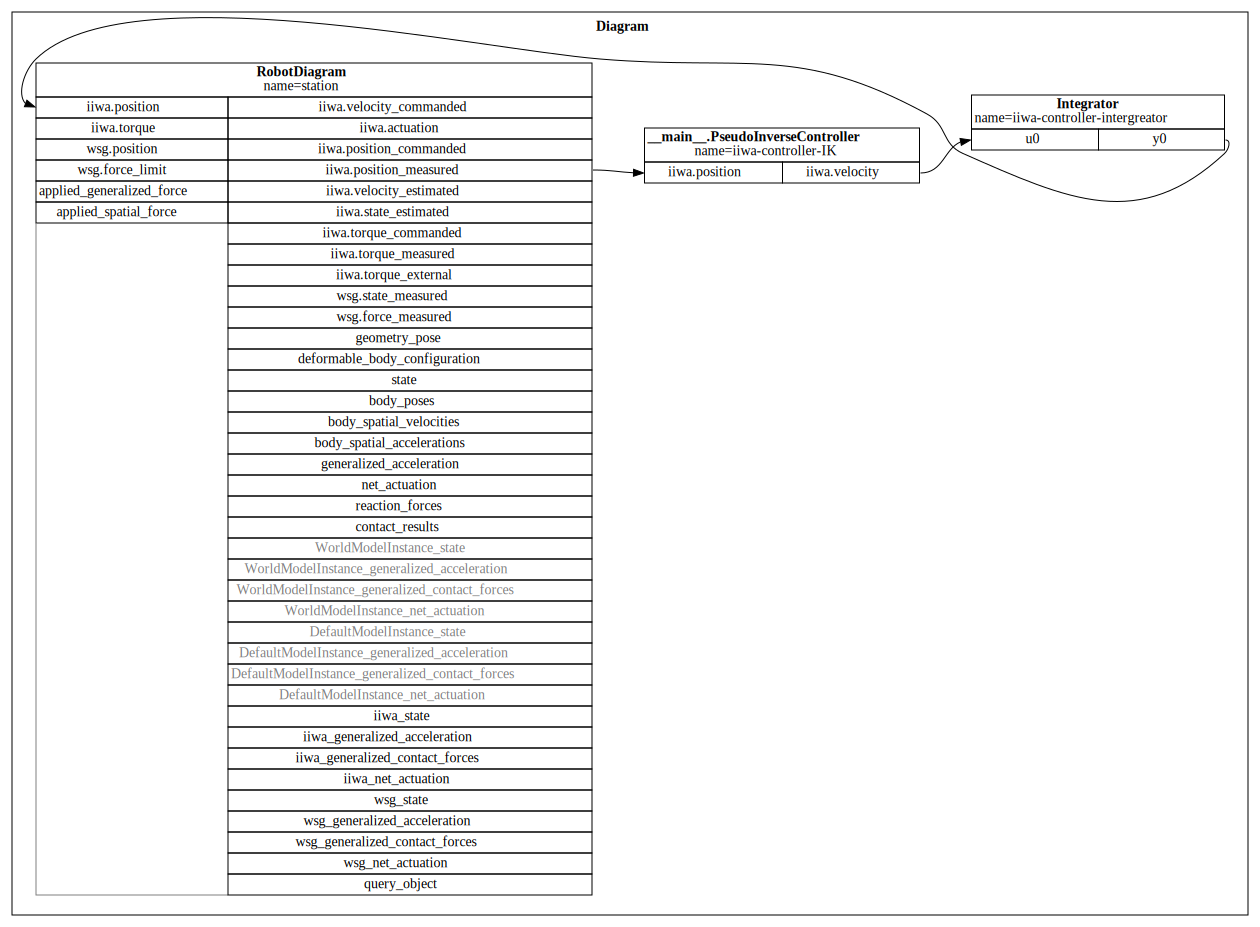

In [3]:
# 我们可以通过继承 LeafSystem 类来编写一个新的 System。
# 这里有一些样板代码，但希望这个例子能让你明白。

class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()  # 末端执行器坐标系
        self._W = plant.world_frame()  # 世界坐标系

        self.DeclareVectorInputPort("iiwa.position", 7)  # 输入端口：iiwa 关节位置
        self.DeclareVectorOutputPort("iiwa.velocity", 7, self.CalcOutput)  # 输出端口：iiwa 关节速度

    def CalcOutput(self, context, output):
        q = self.get_input_port().Eval(context)  # 获取输入端口的当前关节位置
        self._plant.SetPositions(self._plant_context, self._iiwa, q)  # 设置 plant 的关节位置
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context,
            JacobianWrtVariable.kQDot,
            self._G,
            [0, 0, 0],
            self._W,
            self._W,
        )
        J_G = J_G[:, 0:7]  # 忽略夹爪相关的项

        V_G_desired = np.array([
            0,      # 绕 x 轴旋转
            -0.1,   # 绕 y 轴旋转
            0,      # 绕 z 轴旋转
            0,      # x 方向平移
            -0.05,  # y 方向平移
            -0.1,   # z 方向平移
        ])
        v = np.linalg.pinv(J_G).dot(V_G_desired)  # 伪逆求解关节速度
        output.SetFromVector(v)  # 输出关节速度

# 定义场景数据，包含 iiwa 和 wsg
scenario_data = """
directives:
- add_directives:
    file: package://manipulation/iiwa_and_wsg.dmd.yaml
model_drivers:
    iiwa: !IiwaDriver
      control_mode: position_and_torque
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""

def jacobian_controller_example():
    builder = DiagramBuilder()  # 创建系统图构建器

    scenario = LoadScenario(data=scenario_data)  # 加载场景
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))  # 添加硬件站
    plant = station.GetSubsystemByName("plant")  # 获取 plant 子系统

    controller = builder.AddNamedSystem("iiwa-controller-IK", PseudoInverseController(plant))  # 添加伪逆控制器
    integrator = builder.AddNamedSystem("iiwa-controller-intergreator", Integrator(7))  # 添加积分器

    builder.Connect(controller.get_output_port(), integrator.get_input_port())  # 控制器输出连接到积分器输入
    builder.Connect(integrator.get_output_port(), station.GetInputPort("iiwa.position"))  # 积分器输出连接到机械臂位置输入
    builder.Connect(
        station.GetOutputPort("iiwa.position_measured"),
        controller.get_input_port(),
    )  # 机械臂测量位置输出连接到控制器输入

    diagram = builder.Build()  # 构建系统图
    plot_system_graphviz(diagram, max_depth=1)  # 可视化系统图

    simulator = Simulator(diagram)  # 创建仿真器
    context = simulator.get_mutable_context()  # 获取可变上下文
    station_context = station.GetMyContextFromRoot(context)  # 获取 station 的上下文
    station.GetInputPort("iiwa.torque").FixValue(station_context, np.zeros((7, 1)))  # 固定力矩输入为 0
    station.GetInputPort("wsg.position").FixValue(station_context, [0.1])  # 固定夹爪位置为 0.1
    integrator.set_integral_value(
        integrator.GetMyContextFromRoot(context),
        plant.GetPositions(
            plant.GetMyContextFromRoot(context),
            plant.GetModelInstanceByName("iiwa"),
        ),
    )  # 设置积分器初值为当前关节位置

    meshcat.StartRecording(set_visualizations_while_recording=False)  # 开始录制动画
    simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)  # 仿真推进到 5 秒（notebook 环境）或 0.1 秒
    meshcat.PublishRecording()  # 发布动画

jacobian_controller_example()  # 运行示例